### Metrics calculation and some plots
Use this notebook to calculate the BWT and FWT scores for the images the network. This works for the registration predictions as well as U-Net predictions. Just set the paths to the networks predictions correctly and the notebook will do the rest.

#### Set paths

In [10]:
nca_exps = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/NCAdapt/WACV_2025_trained_models_Hip/Experiments/Seq'
nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/Adjust'
# nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/Adjust_light_50_epochs_no_schedule_no_optim'
# nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/Adjust_light_250_epochs'
# nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/Adjust_advanced'
# nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/Freeze_all_but_convs'
# nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/Frozen_nca_0'
# nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/Frozen_nca_1'
# nca_CL = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/Single_adjust'
# reh_exps =   '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/Reh'
ewc_exps =   '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/EWC'
rwalk_exps = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/RWalk'

#### Import necessary libraries

In [11]:
from math import pi
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os, copy, monai, torch
from tqdm.notebook import trange, tqdm

#### Helpful functions and other stuffs

In [12]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

### NCA results

In [13]:
models = [x for x in os.listdir(nca_exps) if 'm3d_nca' in x.lower()]

models.sort()
dices_s = dict()
for model in models:
    dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(nca_exps, model)) if 'inference' in x]

    for pred in preds_:
        preds = os.path.join(nca_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_s[model.replace('_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/Seq/M3D_NCA_Hyp97_None/inference..
Dice for model M3D_NCA_Hyp97_None:


Task97_DecathHip: Mean dice +/- std: 83.79 (4.3)
Task98_Dryad: Mean dice +/- std: 0.0 (0.0)
Task99_HarP: Mean dice +/- std: 2.41 (5.12)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/Seq/M3D_NCA_Hyp98_None/inference..
Dice for model M3D_NCA_Hyp98_None:
Task97_DecathHip: Mean dice +/- std: 0.0 (0.0)
Task98_Dryad: Mean dice +/- std: 89.05 (1.17)
Task99_HarP: Mean dice +/- std: 53.1 (20.82)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/Seq/M3D_NCA_Hyp99_98_97_None/inference..
Dice for model M3D_NCA_Hyp99_98_97_None:
Task97_DecathHip: Mean dice +/- std: 87.22 (2.86)
Task98_Dryad: Mean dice +/- std: 0.03 (0.09)
Task99_HarP: Mean dice +/- std: 1.0 (2.97)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/Seq/M3D_NCA_Hyp99_98_None/inference..
Dice for model M3D_NCA_Hyp99_98_None:
Task97_DecathHip: Mean dice +/- std: 0.54 (2.69)
Task98_Dryad: Mean d

In [14]:
models = [x for x in os.listdir(nca_CL) if 'm3d_nca' in x.lower()]

models.sort()
dices_cl = dict()
for model in models: # _CL_adjust_dict_new_p0s_None
    dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(nca_CL, model)) if 'inference' in x]

    for pred in preds_:
        preds = os.path.join(nca_CL, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_cl[model.replace('_CL_adjust_dict_new_p0s_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/Adjust/M3D_NCA_Hyp97_CL_adjust_dict_new_p0s_None/inference..
Dice for model M3D_NCA_Hyp97_CL_adjust_dict_new_p0s_None:
Task97_DecathHip: Mean dice +/- std: 16.9 (21.59)
Task98_Dryad: Mean dice +/- std: 0.65 (0.95)
Task99_HarP: Mean dice +/- std: 10.77 (20.07)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/Adjust/M3D_NCA_Hyp98_CL_adjust_dict_new_p0s_None/inference..
Dice for model M3D_NCA_Hyp98_CL_adjust_dict_new_p0s_None:
Task97_DecathHip: Mean dice +/- std: 0.92 (1.81)
Task98_Dryad: Mean dice +/- std: 89.5 (1.27)
Task99_HarP: Mean dice +/- std: 50.06 (23.05)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/Adjust/M3D_NCA_Hyp99_98_97_CL_adjust_dict_new_p0s_None/inference..
Dice for model M3D_NCA_Hyp99_98_97_CL_adjust_dict_new_p0s_None:
Task97_DecathHip: Mean dice +/- std: 77.64 (6.22)
Task98_Dry

In [7]:
# Rehearsal
models = [x for x in os.listdir(reh_exps)  if 'm3d_nca' in x.lower()]

models.sort()
dices_reh = dict()
for model in models:
    dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(reh_exps, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(reh_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_reh[model.replace('_reh_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

NameError: name 'reh_exps' is not defined

In [15]:
# EWC
models = [x for x in os.listdir(ewc_exps)  if 'm3d_nca' in x.lower()]

models.sort()
dices_ewc = dict()
for model in models:
    dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(ewc_exps, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(ewc_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_ewc[model.replace('_ewc_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/EWC/M3D_NCA_Hyp97_ewc_None/inference..
Dice for model M3D_NCA_Hyp97_ewc_None:
Task97_DecathHip: Mean dice +/- std: 83.79 (4.3)
Task98_Dryad: Mean dice +/- std: 0.0 (0.0)
Task99_HarP: Mean dice +/- std: 2.41 (5.12)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/EWC/M3D_NCA_Hyp98_ewc_None/inference..
Dice for model M3D_NCA_Hyp98_ewc_None:
Task97_DecathHip: Mean dice +/- std: 0.0 (0.0)
Task98_Dryad: Mean dice +/- std: 89.05 (1.17)
Task99_HarP: Mean dice +/- std: 53.1 (20.82)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/EWC/M3D_NCA_Hyp99_98_97_ewc_None/inference..
Dice for model M3D_NCA_Hyp99_98_97_ewc_None:
Task97_DecathHip: Mean dice +/- std: 81.03 (4.37)
Task98_Dryad: Mean dice +/- std: 34.11 (16.35)
Task99_HarP: Mean dice +/- std: 66.5 (19.58)

Looking in /media/aranem_locale/AR_subs_exps/WA

In [16]:
# RWalk
models = [x for x in os.listdir(rwalk_exps)  if 'm3d_nca' in x.lower()]

models.sort()
dices_rwalk = dict()
for model in models:
    dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(rwalk_exps, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(rwalk_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_rwalk[model.replace('_rwalk_None', '').replace('M3D_NCA_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/RWalk/M3D_NCA_Hyp97_rwalk_None/inference..
Dice for model M3D_NCA_Hyp97_rwalk_None:


Task97_DecathHip: Mean dice +/- std: 83.79 (4.3)
Task98_Dryad: Mean dice +/- std: 0.0 (0.0)
Task99_HarP: Mean dice +/- std: 2.41 (5.12)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/RWalk/M3D_NCA_Hyp98_rwalk_None/inference..
Dice for model M3D_NCA_Hyp98_rwalk_None:
Task97_DecathHip: Mean dice +/- std: 0.0 (0.0)
Task98_Dryad: Mean dice +/- std: 89.05 (1.17)
Task99_HarP: Mean dice +/- std: 53.1 (20.82)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/RWalk/M3D_NCA_Hyp99_98_97_rwalk_None/inference..
Dice for model M3D_NCA_Hyp99_98_97_rwalk_None:
Task97_DecathHip: Mean dice +/- std: 0.06 (0.5)
Task98_Dryad: Mean dice +/- std: 78.53 (5.05)
Task99_HarP: Mean dice +/- std: 85.19 (7.24)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/RWalk/M3D_NCA_Hyp99_98_rwalk_None/inference..
Dice for model M3D_NCA_Hyp99_98_rwalk_None:
Task97_DecathHip: Mean dic

In [17]:
data = {'NCA': dices_s, 'NCA_adjust': dices_cl, 'EWC': dices_ewc, 'RWalk': dices_rwalk, #'Rehearsal': dices_reh
       }

#### Forgetting, Positive Backward Transfer, Remembering and Forward Transfer

In [18]:
tasks = ['99', '98', '97']
methods = ['NCA', 'NCA_adjust', 'EWC', 'RWalk']#, 'Rehearsal']
B_T, F_T, F_NEG, F_POS, B_TP, FOR, REM, Dice, Dice_F, Dice_L, STD = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
Dice_2 = dict()

all_t_j = '_'.join(tasks)
for m in methods:
    B_T[m], F_T[m], F_NEG[m], F_POS[m], B_TP[m], FOR[m], REM[m], Dice[m], Dice_F[m], Dice_L[m], STD[m] = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    Dice_2[m] = dict()
    t_list = list()
    for t in tasks:
        t_list.append(t)
        Dice_t_all = (data[m][all_t_j][t]['mean_dice_moved'],
                        data[m][all_t_j][t]['mean_std_moved'])
        
        Dice_t = (data[m]['_'.join(t_list)][t]['mean_dice_moved'],
                    data[m]['_'.join(t_list)][t]['mean_std_moved'])
        
        if len(t_list) > 1:
            Dice_t_prev = (data[m]['_'.join(t_list[:-1])][t]['mean_dice_moved'],
                            data[m]['_'.join(t_list[:-1])][t]['mean_std_moved'])
            F_T[m][t] = Dice_t_prev[0] - data[m][t][t]['mean_dice_moved']
            F_NEG[m][t] = abs(min(F_T[m][t], 0))
            F_POS[m][t] = 1 - abs(min(F_T[m][t], 0))
        
        if '_'.join(t_list) == all_t_j: # Only add this once
            Dice_F[m][t] = data[m][all_t_j][tasks[0]]['mean_dice_moved']
            Dice_2[m][t] = data[m][all_t_j][tasks[1]]['mean_dice_moved']
            Dice_L[m][t] = data[m][all_t_j][tasks[2]]['mean_dice_moved']
        
        Dice[m][t] = data[m][all_t_j][t]['mean_dice_moved']

        if '_'.join(t_list) != all_t_j:
            B_T[m][t] = Dice_t_all[0] - Dice_t[0]
            B_TP[m][t] = max(B_T[m][t], 0)
            FOR[m][t] = abs(min(B_T[m][t], 0))
            REM[m][t] = 1 - abs(min(B_T[m][t], 0))

In [19]:
print('BWT, FWT [%]')
for m in methods:
    print(m)
    # print(np.asarray(list(B_T[m].values()))*100)
    print(np.mean(np.asarray(list(B_T[m].values()))*100), '+\-', np.std(np.asarray(list(B_T[m].values()))*100))
    print(np.mean(np.asarray(list(F_T[m].values()))*100), '+\-', np.std(np.asarray(list(F_T[m].values()))*100))
    # print(np.mean(np.asarray(list(Dice[m].values()))*100), '+\-', np.std(np.asarray(list(Dice[m].values()))*100))

BWT, FWT [%]
NCA
-86.38620992462772 +\- 3.5459174235196116
-45.09194813928983 +\- 38.14921282492063
NCA_adjust
-0.4359023217801683 +\- 0.10300501629157965
-13.706690714680004 +\- 3.1975788334239086
EWC
-35.914933999689914 +\- 17.304892286968734
-47.70976106263193 +\- 32.88260916806254
RWalk
0.02279108873119995 +\- 0.09037309774646562
-47.00196472188579 +\- 36.727631960121265


In [20]:
print('Mean Dice [%]')
for m in methods:
    print(m)
    print(np.mean(list(Dice[m].values()))*100)
    print(np.std(list(Dice[m].values()))*100)

Mean Dice [%]
NCA
29.419694513426116
40.88292548365254
NCA_adjust
81.61258944631302
2.8204076242921414
EWC
60.54746965983845
19.613481731719077
RWalk
54.59776443435316
38.659191749810375


In [21]:
print('Mean Forgetting [%]')
for m in methods:
    print(m)
    print(np.mean(list(FOR[m].values()))*100)

Mean Forgetting [%]
NCA
86.3862099246277
NCA_adjust
0.4359023217801683
EWC
35.914933999689914
RWalk
0.03379100450763284


#### Spider Plots

In [26]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'Dice Mean': [np.mean(list(Dice[m].values()))*100 for m in methods],
'100 + BWT': [100 + np.mean(list(B_T[m].values()))*100 for m in methods],
'Dice Last': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
'Dice First': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'100 + FWT': [100 + np.mean(list(F_T[m].values()))*100 for m in methods]
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # ax.xaxis.set_tick_params(pad=35)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    
    for i, tick in enumerate(ax.get_xaxis().get_major_ticks()):
        if i == 1 or i == 4:
            tick.set_pad(35)
        else:
            tick.set_pad(15)

    # Draw ylabels
    # ax.set_rlabel_position(0)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=9)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

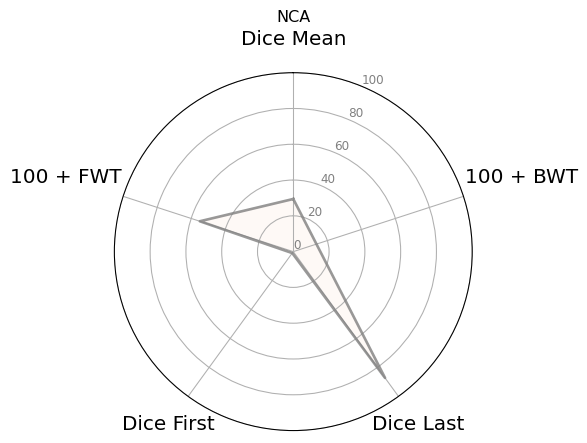

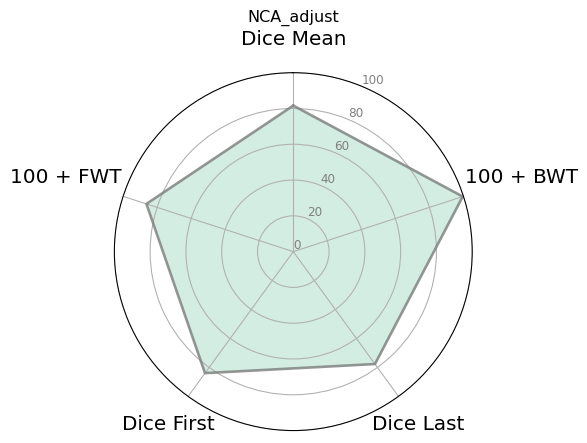

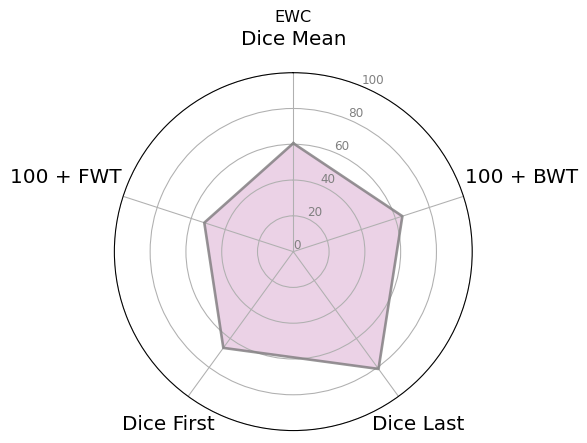

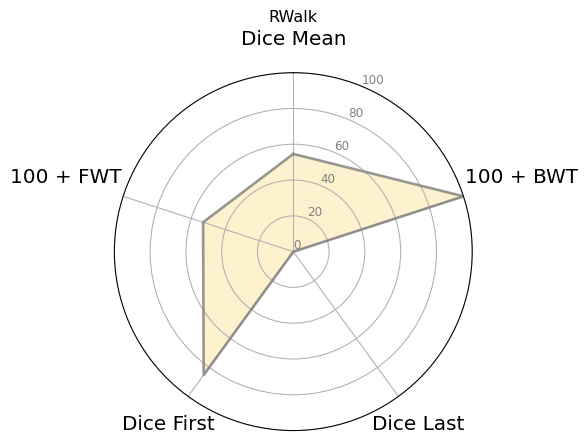

In [27]:
# ------- PART 2: Apply the function to all individuals
colors = {'NCA': '#fae5d6', 'NCA_adjust': '#26a671', 'RWalk':'#fec10b', 'EWC':'#9e1e83'}#, 'Rehearsal': '#26a671'

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_evaluation/plots/hip_spiders_{title}.pdf', bbox_inches='tight')

In [15]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'$\mathcal{T}_{1}$': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'$\mathcal{T}_{2}$': [np.mean(list(Dice_2[m].values()))*100 for m in methods],
'$\mathcal{T}_{3}$': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.xaxis.set_tick_params(pad=15)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    # plt.xticks(angles[:-1], categories, color='black', size=15)
    plt.xticks(angles[:-1], categories, color='black', size=31)
    
    # Draw ylabels
    # ax.set_rlabel_position(0)
    # plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=11)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=15)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

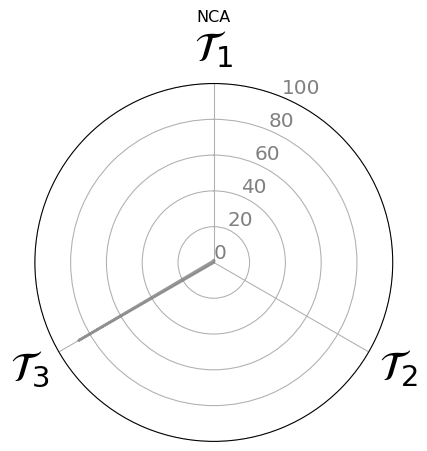

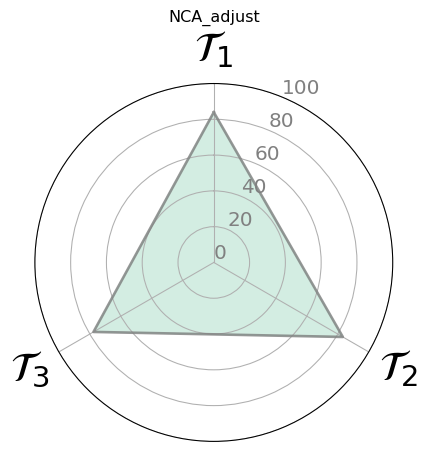

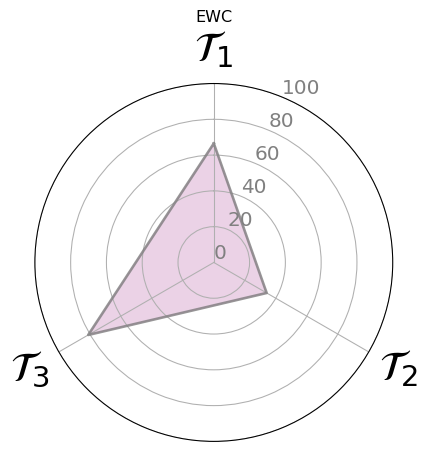

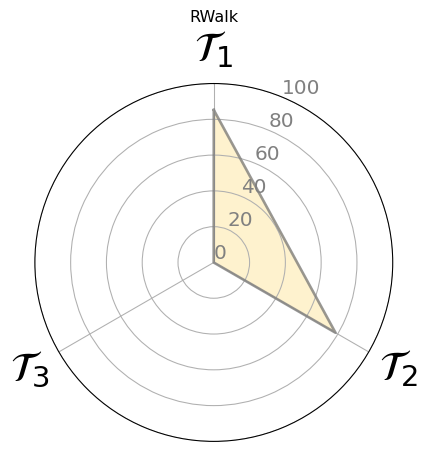

In [16]:
# ------- PART 2: Apply the function to all individuals
colors = {'NCA': '#fae5d6', 'NCA_adjust': '#26a671', 'RWalk':'#fec10b', 'EWC':'#9e1e83'}#, 'Rehearsal': '#26a671'

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_evaluation/plots/hip_spiders_{title}_dices.pdf', bbox_inches='tight')